<a href="https://colab.research.google.com/drive/1SKGWjFt1pUmD4_YTNG731tkOJ1XBUSrR?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Supervised contrastive learning  - Using new loss 

**Submitted By: Aryan Jadon**

##Normalize Projections

In [28]:
!pip install tensorflow-addons
!pip install losses

ERROR: Could not find a version that satisfies the requirement losses (from versions: none)
ERROR: No matching distribution found for losses


In [29]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Models

In [30]:
import tensorflow as tf


class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])


class DenseLeakyReluLayer(tf.keras.layers.Layer):
    '''A dense layer followed by a LeakyRelu layer
    '''

    def __init__(self, n, alpha=0.3):
        super(DenseLeakyReluLayer, self).__init__()
        self.dense = tf.keras.layers.Dense(n, activation=None)
        self.lrelu = tf.keras.layers.LeakyReLU(alpha=alpha)

    def call(self, input_tensor):
        x = self.dense(input_tensor)
        return self.lrelu(x)


class Encoder(tf.keras.Model):
    '''An encoder network, E(·), which maps an augmented image x to a representation vector, r = E(x) ∈ R^{DE}
    '''

    def __init__(self, normalize=True, activation='relu'):
        super(Encoder, self).__init__(name='')
        if activation == 'leaky_relu':
            self.hidden1 = DenseLeakyReluLayer(256)
            self.hidden2 = DenseLeakyReluLayer(256)
        else:
            self.hidden1 = tf.keras.layers.Dense(256, activation=activation)
            self.hidden2 = tf.keras.layers.Dense(256, activation=activation)

        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()

    def call(self, input_tensor, training=False):
        x = self.hidden1(input_tensor, training=training)
        x = self.hidden2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        return x


class Projector(tf.keras.Model):
    '''
    A projection network, P(·), which maps the normalized representation vector r into a vector z = P(r) ∈ R^{DP} 
    suitable for computation of the contrastive loss.
    '''

    def __init__(self, n, normalize=True, activation='relu'):
        super(Projector, self).__init__(name='')
        if activation == 'leaky_relu':
            self.dense = DenseLeakyReluLayer(256)
            self.dense2 = DenseLeakyReluLayer(256)
        else:
            self.dense = tf.keras.layers.Dense(256, activation=activation)
            self.dense2 = tf.keras.layers.Dense(256, activation=activation)

        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()

    def call(self, input_tensor, training=False):
        x = self.dense(input_tensor, training=training)
        x = self.dense2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        return x


class SoftmaxPred(tf.keras.Model):
    '''For stage 2, simply a softmax on top of the Encoder.
    '''

    def __init__(self, num_classes=10):
        super(SoftmaxPred, self).__init__(name='')
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, input_tensor, training=False):
        return self.dense(input_tensor, training=training)


class MLP(tf.keras.Model):
    '''A simple baseline MLP with the same architecture to Encoder + Softmax/Regression output.
    '''

    def __init__(self, num_classes=10, normalize=True, regress=False, activation='relu'):
        super(MLP, self).__init__(name='')
        if activation == 'leaky_relu':
            self.hidden1 = DenseLeakyReluLayer(256)
            self.hidden2 = DenseLeakyReluLayer(256)
        else:
            self.hidden1 = tf.keras.layers.Dense(256, activation=activation)
            self.hidden2 = tf.keras.layers.Dense(256, activation=activation)
        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()
        if not regress:
            self.output_layer = tf.keras.layers.Dense(
                num_classes, activation='softmax')
        else:
            self.output_layer = tf.keras.layers.Dense(1)

    def call(self, input_tensor, training=False):
        x = self.hidden1(input_tensor, training=training)
        x = self.hidden2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        preds = self.output_layer(x, training=training)
        return preds

    def get_last_hidden(self, input_tensor):
        '''Get the last hidden layer before prediction.
        '''
        x = self.hidden1(input_tensor, training=False)
        x = self.hidden2(x, training=False)
        if self.normalize:
            x = self.norm(x)
        return x

## Losses

In [31]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa


def pdist_euclidean(A):
    # Euclidean pdist
    r = tf.reduce_sum(A*A, 1)
    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


def square_to_vec(D):
    '''Convert a squared form pdist matrix to vector form.
    '''
    n = D.shape[0]
    triu_idx = np.triu_indices(n, k=1)
    d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses 
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].    
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss. 
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from: 
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

In [32]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [33]:
# global configs
EPOCHS = 20
DATA = 'fashion_mnist'
NORMALIZE_EMBEDDING = True
N_DATA_TRAIN = 60000
BATCH_SIZE = 1024 # batch_size for pre-training
PROJECTION_DIM = 128
WRITE_SUMMARY = False
ACTIVATION = 'leaky_relu'
LR = 0.5 # learning rate for pre-training

In [34]:
!mkdir -p logs/
optimizer = tf.keras.optimizers.Adam(lr=LR)
optimizer2 = tf.keras.optimizers.Adam() # with default lr

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


##Load MNIST data

In [35]:
if DATA == 'mnist':
    mnist = tf.keras.datasets.mnist
elif DATA == 'fashion_mnist':
    mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28).astype(np.float32)
x_test = x_test.reshape(-1, 28*28).astype(np.float32)
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [36]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [37]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

train_ds2 = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Multi Class N-pairs loss

###Stage 1: train encoder with multiclass N-pair loss

In [38]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [39]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [40]:
@tf.function
# train step for the multiclass N-pair loss
def train_step_npair(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = multiclass_npairs_loss(z, y)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

In [41]:
@tf.function
def test_step_npair(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = multiclass_npairs_loss(z, y)
    test_loss(t_loss)

In [42]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        train_step_npair(x, y)

    for x_te, y_te in test_ds:
        test_step_npair(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        test_loss.result()))

Epoch 1, Loss: 6.416478157043457, Test Loss: 6.330540657043457
Epoch 2, Loss: 6.317351818084717, Test Loss: 6.282473564147949
Epoch 3, Loss: 6.283567905426025, Test Loss: 6.265685081481934
Epoch 4, Loss: 6.261258602142334, Test Loss: 6.246369361877441
Epoch 5, Loss: 6.250873565673828, Test Loss: 6.237844467163086
Epoch 6, Loss: 6.2430806159973145, Test Loss: 6.227111339569092
Epoch 7, Loss: 6.233381748199463, Test Loss: 6.218486309051514
Epoch 8, Loss: 6.223250865936279, Test Loss: 6.206966876983643
Epoch 9, Loss: 6.2135419845581055, Test Loss: 6.207026958465576
Epoch 10, Loss: 6.207067012786865, Test Loss: 6.196354866027832
Epoch 11, Loss: 6.199909687042236, Test Loss: 6.193297386169434
Epoch 12, Loss: 6.200615882873535, Test Loss: 6.187169551849365
Epoch 13, Loss: 6.194498062133789, Test Loss: 6.187121868133545
Epoch 14, Loss: 6.192956924438477, Test Loss: 6.196320533752441
Epoch 15, Loss: 6.189671993255615, Test Loss: 6.181724548339844
Epoch 16, Loss: 6.185924530029297, Test Loss: 6

In [43]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [44]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape


TensorShape([10000, 256])

In [45]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


###Check learned embedding

In [46]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [47]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [48]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


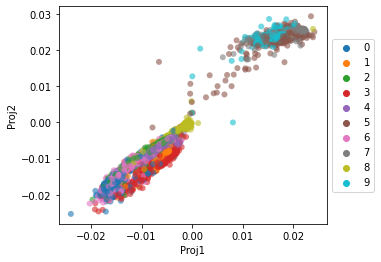

In [49]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


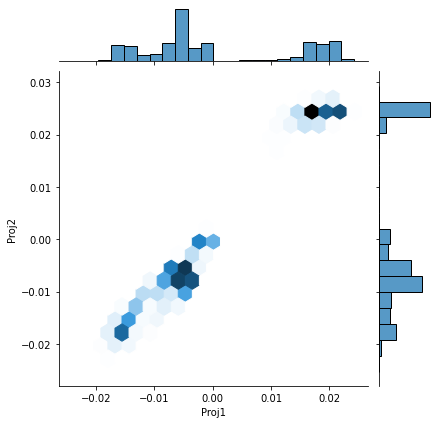

In [50]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );


In [51]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


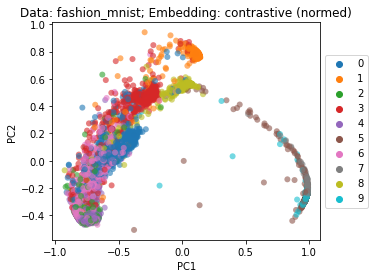

In [52]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


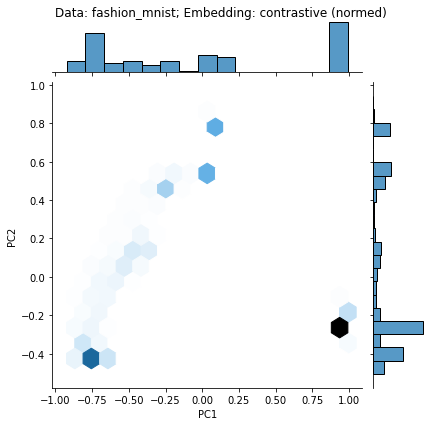

In [53]:
g = sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);

In [54]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


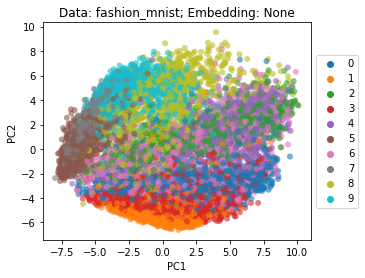

In [55]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_no_embed.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


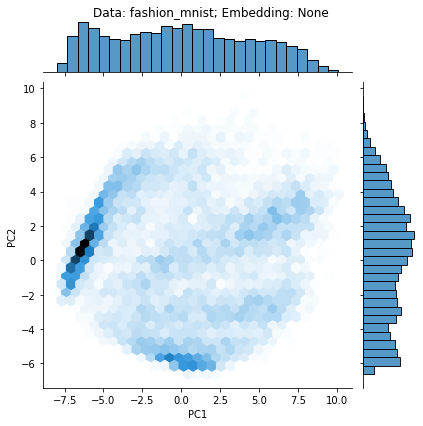

In [56]:
g = sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);

##Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [57]:
softmax = SoftmaxPred()

In [58]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [59]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [60]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer2.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [61]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [62]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [63]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds2:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.932508647441864, Acc: 72.72166442871094, Test Loss: 0.6710332632064819, Test Acc: 76.45000457763672
Epoch 2, Loss: 0.5907922387123108, Acc: 79.2249984741211, Test Loss: 0.6008834838867188, Test Acc: 78.06999969482422
Epoch 3, Loss: 0.5455392003059387, Acc: 80.44166564941406, Test Loss: 0.5755971670150757, Test Acc: 79.31999969482422
Epoch 4, Loss: 0.5256397724151611, Acc: 81.11000061035156, Test Loss: 0.5629509091377258, Test Acc: 79.8699951171875
Epoch 5, Loss: 0.5138375759124756, Acc: 81.49333953857422, Test Loss: 0.5547656416893005, Test Acc: 79.75999450683594
Epoch 6, Loss: 0.5056771039962769, Acc: 81.69999694824219, Test Loss: 0.5477372407913208, Test Acc: 80.11000061035156
Epoch 7, Loss: 0.4993952214717865, Acc: 81.87833404541016, Test Loss: 0.5422626733779907, Test Acc: 80.41999816894531
Epoch 8, Loss: 0.4942967891693115, Acc: 82.04833221435547, Test Loss: 0.5379096269607544, Test Acc: 80.47999572753906
Epoch 9, Loss: 0.48979058861732483, Acc: 82.2683334350586, 

In [64]:
test_acc.result().numpy()

0.8161

##Supervised NT-Xent

In [65]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [66]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [67]:
@tf.function
# train step for the multiclass N-pair loss
def train_step_sup_nt_xent(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = supervised_nt_xent_loss(z, y, temperature=0.1)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)


In [68]:
@tf.function
def test_step_sup_nt_xent(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = supervised_nt_xent_loss(z, y, temperature=0.1)
    test_loss(t_loss)

In [69]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        train_step_sup_nt_xent(x, y)

    for x_te, y_te in test_ds:
        test_step_sup_nt_xent(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        test_loss.result()))

Epoch 1, Loss: 8.721634864807129, Test Loss: 8.548921585083008
Epoch 2, Loss: 8.494731903076172, Test Loss: 8.438345909118652
Epoch 3, Loss: 8.404888153076172, Test Loss: 8.358540534973145
Epoch 4, Loss: 8.318581581115723, Test Loss: 8.289693832397461
Epoch 5, Loss: 8.260108947753906, Test Loss: 8.245240211486816
Epoch 6, Loss: 8.213942527770996, Test Loss: 8.204468727111816
Epoch 7, Loss: 8.170205116271973, Test Loss: 8.167110443115234
Epoch 8, Loss: 8.120866775512695, Test Loss: 8.108250617980957
Epoch 9, Loss: 8.05292797088623, Test Loss: 8.054862976074219
Epoch 10, Loss: 7.98305082321167, Test Loss: 7.973785400390625
Epoch 11, Loss: 7.913976669311523, Test Loss: 7.886953830718994
Epoch 12, Loss: 7.8119072914123535, Test Loss: 7.826851844787598
Epoch 13, Loss: 7.746976375579834, Test Loss: 7.757979393005371
Epoch 14, Loss: 7.704482078552246, Test Loss: 7.742215156555176
Epoch 15, Loss: 7.665741443634033, Test Loss: 7.7171783447265625
Epoch 16, Loss: 7.644890785217285, Test Loss: 7.6

In [70]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [71]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [72]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


##Check learned embedding

In [73]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [74]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [75]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


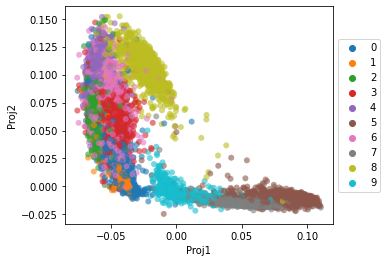

In [76]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


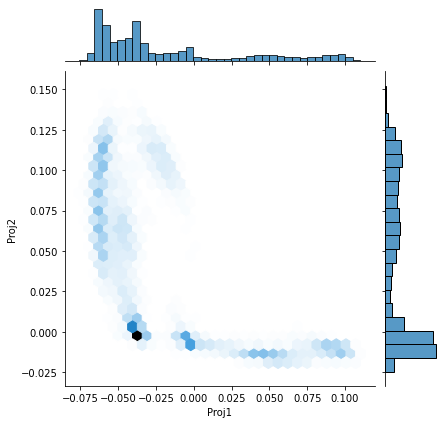

In [77]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );

In [78]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


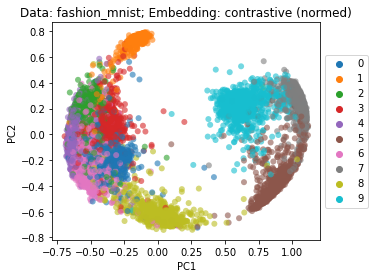

In [79]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


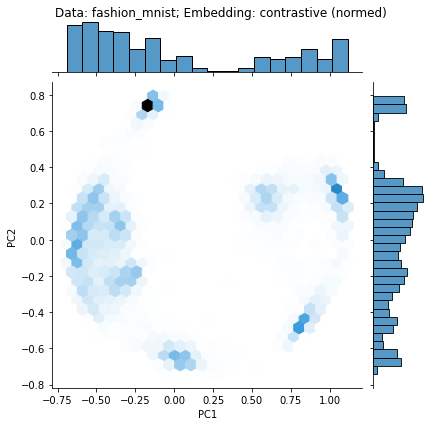

In [80]:
g = sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);

In [81]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


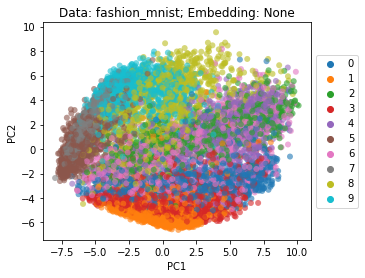

In [82]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


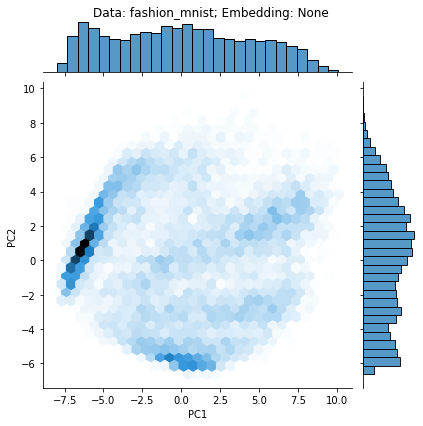

In [83]:
g = sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);

##Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [84]:
softmax = SoftmaxPred()

In [85]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')


In [86]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [87]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer2.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [88]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)

    t_loss = cce_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_acc(y, y_preds)

In [89]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)


In [90]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds2:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.8376985192298889, Acc: 77.73666381835938, Test Loss: 0.6655253767967224, Test Acc: 80.61000061035156
Epoch 2, Loss: 0.5819098949432373, Acc: 82.72167205810547, Test Loss: 0.5751761198043823, Test Acc: 81.87000274658203
Epoch 3, Loss: 0.5165683031082153, Acc: 83.9000015258789, Test Loss: 0.5320502519607544, Test Acc: 82.70999908447266
Epoch 4, Loss: 0.48224905133247375, Acc: 84.49166107177734, Test Loss: 0.5088235139846802, Test Acc: 83.20000457763672
Epoch 5, Loss: 0.4614218473434448, Acc: 84.8933334350586, Test Loss: 0.4926548898220062, Test Acc: 83.5
Epoch 6, Loss: 0.447521448135376, Acc: 85.163330078125, Test Loss: 0.4826980531215668, Test Acc: 83.69000244140625
Epoch 7, Loss: 0.43755441904067993, Acc: 85.36499786376953, Test Loss: 0.4748547077178955, Test Acc: 83.7300033569336
Epoch 8, Loss: 0.4300900101661682, Acc: 85.45833587646484, Test Loss: 0.4691838324069977, Test Acc: 83.77999877929688
Epoch 9, Loss: 0.4242776036262512, Acc: 85.65999603271484, Test Loss: 0.4